In [1]:
import warnings
warnings.filterwarnings("ignore")

import fastai.utils
from fastai.vision import *
from fastai.callbacks import *
from fastcore.foundation import delegates

from knockknock import email_sender

In [2]:
fastai.utils.collect_env.show_install()



```text
=== Software === 
python        : 3.8.3
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.6.0
nvidia driver : 450.57
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11016MB | GeForce RTX 2080 Ti

=== Environment === 
platform      : Linux-5.4.0-42-generic-x86_64-with-glibc2.10
distro        : Ubuntu 18.04 bionic
conda env     : base
python        : /opt/conda/bin/python
sys.path      : /workspace
/opt/conda/lib/python38.zip
/opt/conda/lib/python3.8
/opt/conda/lib/python3.8/lib-dynload

/opt/conda/lib/python3.8/site-packages
/opt/conda/lib/python3.8/site-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



In [3]:
root_dir = Path('/')
data_dir = root_dir / 'data' / 'chest_xray'
model_dir = Path('.').absolute() / 'models'

In [4]:
sz = 256
lr = defaults.lr
bs = 64
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

In [5]:
def valid_func(o: Path):
    return 'test' in str(o)

def label_func(o: Path):
    if 'virus' in o.name:
        return 'pneumonia'
    if 'bacteria' in o.name:
        return 'pneumonia'
    return 'normal'

data = (ImageList.from_folder(data_dir)
        .split_by_valid_func(valid_func)
        .label_from_func(label_func)
        .transform(get_transforms(), size=sz)
        .databunch(bs=bs)
        .normalize(stats)
        )

data, data.classes

(ImageDataBunch;
 
 Train: LabelList (5232 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: CategoryList
 pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
 Path: /data/chest_xray;
 
 Valid: LabelList (624 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: CategoryList
 pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
 Path: /data/chest_xray;
 
 Test: None,
 ['normal', 'pneumonia'])

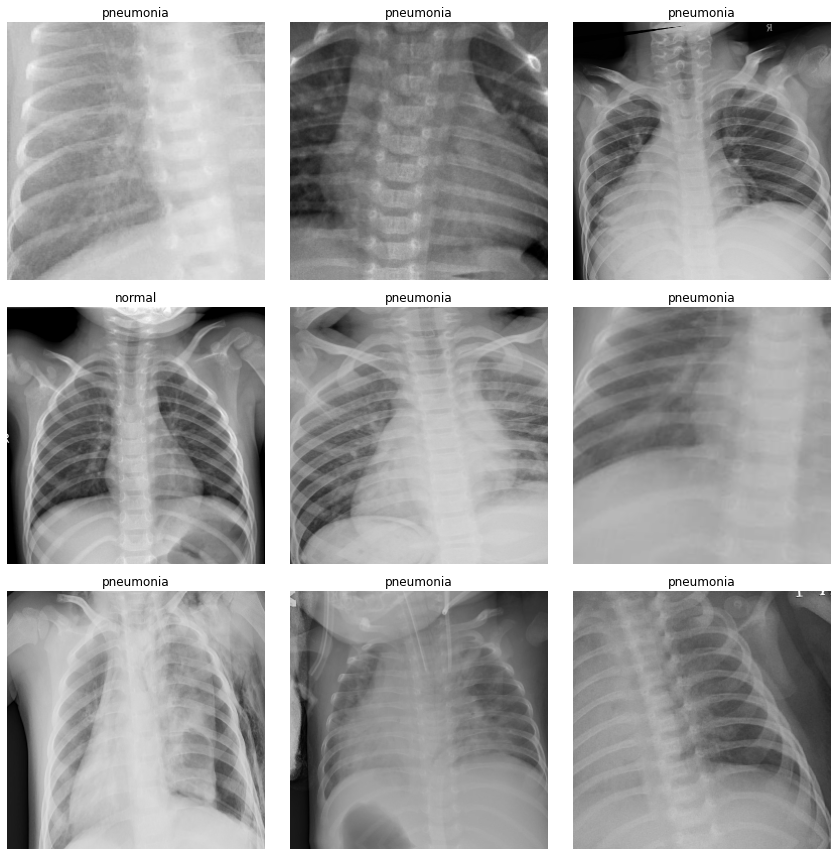

In [6]:
data.show_batch(rows=3)

In [7]:
learn = cnn_learner(data,
                    models.resnet50,
                    metrics=error_rate,
                    bn_wd=False,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[BnFreeze,
                                  partial(SaveModelCallback, monitor='error_rate', name='best_error'),
                                 ],
                    model_dir=model_dir,
                   ).to_fp16()

cb_showgraph = ShowGraph(learn)
learn.callbacks.append(cb_showgraph)

In [10]:
@email_sender(recipient_emails=["yyang@hbku.edu.qa"], sender_email="hbkubot@gmail.com")
@delegates(learn.fit_one_cycle)
def train(learn, name, lr, n_epochs=5, **kwargs): # must be called kwargs, not kw_args or anything else
    learn.fit_one_cycle(n_epochs, lr, **kwargs)
    learn.save(name)

epoch,train_loss,valid_loss,error_rate,time
0,0.649976,0.656008,0.153846,00:31
1,0.406081,0.492776,0.150641,00:30
2,0.327312,0.427074,0.142628,00:30
3,0.292135,0.420274,0.133013,00:30
4,0.286732,0.407175,0.123397,00:30


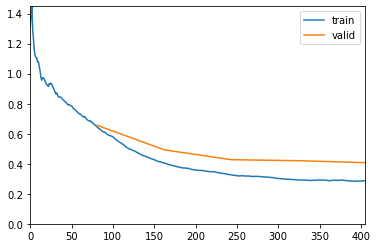

Better model found at epoch 0 with error_rate value: 0.1538461595773697.
Better model found at epoch 1 with error_rate value: 0.15064102411270142.
Better model found at epoch 2 with error_rate value: 0.14262820780277252.
Better model found at epoch 3 with error_rate value: 0.1330128163099289.
Better model found at epoch 4 with error_rate value: 0.12339743226766586.


In [9]:
train(learn, 'stage_1', lr)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.63E-06


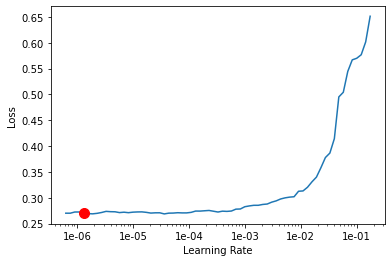

In [10]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.274035,0.392801,0.115385,00:31
1,0.266917,0.388923,0.112179,00:31
2,0.257993,0.345527,0.089744,00:31
3,0.245180,0.347122,0.081731,00:31
4,0.243656,0.365622,0.092949,00:31


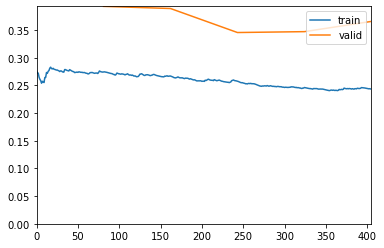

Better model found at epoch 0 with error_rate value: 0.11538461595773697.
Better model found at epoch 1 with error_rate value: 0.11217948794364929.
Better model found at epoch 2 with error_rate value: 0.08974359184503555.
Better model found at epoch 3 with error_rate value: 0.08173076808452606.


In [11]:
lr = 3e-4
train(learn, 'stage_2', slice(lr/100, lr))

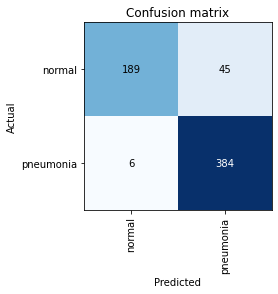

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()